In [1]:
import os
import sys 
import glob
import dask
import pyproj
import copy
import dask
import xsar
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr

import dask.array as da
import cmcrameri.cm as cmc
import drama.utils as drtls
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [2]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import round_to_hour, angular_difference, calculate_distance

In [3]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenario_1 = 'Morroco_20201022'
scenario_2 = 'Morroco_20201103'

find_files = lambda x, data_dir: glob.glob(f"{data_dir+x}/*.SAFE")

In [5]:
pre = S1DopplerLeakage(
    filename=find_files(scenario_1, data_dir),
    # f0=26.5e9,
    era5_directory='era5_winds/',
    resolution_product=25_000,
    az_footprint_cutoff=80_000,
    vx_sat=6800,
    PRF=4,
    grid_spacing=150,
    antenna_length=3.2,
    antenna_height=0.3,
    beam_pattern='phased_array',
    antenna_elements=4,
    antenna_weighting=0.5,
    incidence_angle_scat=40,
    random_state=42, # <--  different random state than below
    )

post = S1DopplerLeakage(
    filename=find_files(scenario_2, data_dir),
    # f0=26.5e9,
    era5_directory='era5_winds/',
    resolution_product=25_000,
    az_footprint_cutoff=80_000,
    vx_sat=6800,
    PRF=4,
    grid_spacing=150,
    antenna_length=3.2,
    antenna_height=0.3,
    beam_pattern='phased_array',
    antenna_elements=4,
    antenna_weighting=0.5,
    incidence_angle_scat=40,
    random_state=41, # <--  different random state than above
    
    )

In [6]:
pre.apply()
post.apply()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Morroco_20201022/39DA_3CC1_46F4_4B73_6453_680F_A98A_C76A_res150.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_20201022h1900_lat35_10_lon-12_80.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Morroco_20201103/0831_0B4E_2DB3_3597_6475_966E_BC59_D53C_res150.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202011.nc


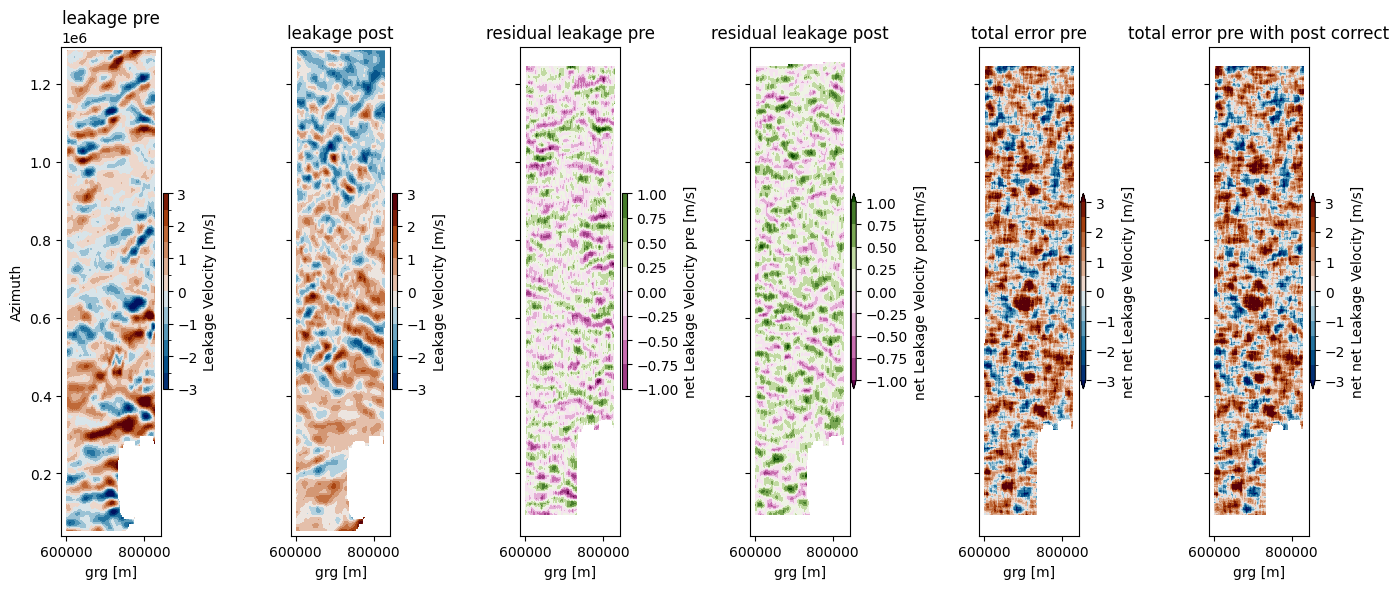

In [13]:
cbar_kwargs = {'shrink':0.4, 'aspect':40, 'pad' : 0.01, 'extend':'neither'}
plot_kwargs = {'robust': True}
plot_leakage_kwargs = {'vmin': -3, 'vmax': 3, 'cmap' : cmc.vik, 'levels' : 13}
plot_leakage_net_kwargs = {'vmin': -1, 'vmax': 1, 'cmap' : cmc.bam, 'levels' : 9}
label_kwargs = {'xlabel':'Range [m]', 'ylabel':'Azimuth [m]'}



plot_cut = post.data.V_leakage_pulse_rg_subscene / post.data.V_leakage_pulse_rg_subscene * pre.data.V_leakage_pulse_rg_subscene / pre.data.V_leakage_pulse_rg_subscene

net_leakage_pre = (pre.data.V_leakage_pulse_rg_subscene - pre.data.V_leakage_pulse_rg_subscene_inverted) * plot_cut
net_leakage_post = (post.data.V_leakage_pulse_rg_subscene - post.data.V_leakage_pulse_rg_subscene_inverted) * plot_cut
net_velocity_error =  (pre.data.V_sigma_subscene - pre.data.V_leakage_pulse_rg_subscene_inverted) * plot_cut
net_net_velocity_error =  (net_velocity_error - net_leakage_post) * plot_cut


nx = 6; ny = 1
fig, axes = plt.subplots(ny, nx, figsize = (14, 6), sharex=True, sharey=True)
axes_indexes = np.argwhere(axes)




(pre.data.V_leakage_pulse_rg_subscene * plot_cut).T.plot(ax= axes[*axes_indexes[0]],#[0,2], 
                                             **{**plot_leakage_kwargs, **plot_kwargs},
                                             cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
(post.data.V_leakage_pulse_rg_subscene * plot_cut).T.plot(ax= axes[*axes_indexes[1]],#[0,2], 
                                             **{**plot_leakage_kwargs, **plot_kwargs},
                                             cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
net_leakage_pre.T.plot(ax= axes[*axes_indexes[2]],#[1,0],
                    **{**plot_leakage_net_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'net Leakage Velocity pre [m/s]', **cbar_kwargs})
net_leakage_post.T.plot.contourf(ax= axes[*axes_indexes[3]],#[1,1],
                    **{**plot_leakage_net_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'net Leakage Velocity post[m/s]', **cbar_kwargs})
(net_velocity_error).T.plot.contourf(ax= axes[*axes_indexes[4]],#[1,2],
                    **{**plot_leakage_net_kwargs, **plot_leakage_kwargs},
                    cbar_kwargs = {'label':'net net Leakage Velocity [m/s]', **cbar_kwargs})
(net_net_velocity_error).T.plot.contourf(ax= axes[*axes_indexes[5]],#[1,2],
                    **{**plot_leakage_net_kwargs, **plot_leakage_kwargs},
                    cbar_kwargs = {'label':'net net Leakage Velocity [m/s]', **cbar_kwargs})

res = post.resolution_product/1000
titles = ['leakage pre', 'leakage post', f'residual leakage pre', 
          f'residual leakage post', f'total error pre', f'total error pre with post correct']
x_labels = [''] * (nx * np.max([0, ny-1])) + ['Range [m]'] * (nx * (ny-1))
y_labels = (['Azimuth'] + [''] * (nx - 1)) * ny
_ = [ax.axes.set_title(i) for ax, i in zip(axes.ravel(), titles)]
_ = [ax.axes.set_xlabel(i) for ax, i in zip(axes.ravel(), x_labels)]
_ = [ax.axes.set_ylabel(i) for ax, i in zip(axes.ravel(), y_labels)]
_ = [ax.axes.set_aspect('equal') for ax in axes.ravel()]

plt.tight_layout()

In [11]:
func_rmse = lambda x:  np.sqrt(np.mean(x**2)).values*1
func_rmse(net_velocity_error), func_rmse(net_net_velocity_error)

(1.3744237973158844, 1.4253142622845105)

In [12]:
func_rmse(net_leakage_pre), func_rmse(net_leakage_post), func_rmse(net_leakage_pre- net_leakage_post)

(0.3341406285762787, 0.3295583724975586, 0.48042500019073486)